# Application of Dynamic Mode Decomposition (DMD), DMD with Control (DMDc) and Extended DMDc (EDMDc)

Here we will be running a simple setup of DMD, DMDc, EDMD and EDMDc on a simple pendulum setup. This will be the base environment we will be using for determining the effacicy of using DMD to approximate the Koopman Operator for this simple mechanical system

In [25]:
#Elis Island
#Here we are just Importing the necessary modules and
import variables as exp
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from pydmd import DMD
from pydmd import DMDc
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

#Plotting configuration
np.set_printoptions(precision=5, suppress=True)
plt.style.use('bmh')
figsize = (12, 5)
dpi = 600    # Resolution in dots per inch

# System measurements
m = exp.m
g = exp.g
l = exp.l
t_span = exp.t_span
b = exp.b
K = exp.K
nvar = exp.nvari
polyorder = exp.order
sineorder = exp.sine
print(K)
duration = int(exp.duration)

[1.6902, 3.6785]


Above we just imputed static characteristics for the system and the linearized SS model.
The LQR derived gain is also imported as well as some of the lifting characteristics. In this specific
example we are preparing to lift the state measurements using a {{$polyorder$}}
order polynomial approximation and a {{$sineorder$}} Fourier approximation.

In [26]:
x0 = np.array([np.pi/4.0, 0.0])
xf = np.array([0.0,0.0])
x_dt=np.array([0., 0.])
def f(t,xk):
    x_1 = xk[1]
    x_2 = -b/m * xk[1] - g/l * np.sin(xk[0])
    ctrl = 1/(m*l**2) * u(xk)
    #print(ctrl)
    return [x_1, x_2+ctrl]

Setup of initial & terminal conditions and definition of nonlinear dynamics for the pendulum system.
Below we run an uncontrolled simulation with the initial conditions {{x0}}. This pendulum setup is undamped and should show a
cyclic behavior which we will then use to feed the DMD algorithms and find the respective Koopman Operators. We will (probably)
not use this specific data set to generate control laws for the system but we will use it as a sanity check for the fidelity
of DMD constructed systems.

In [27]:
u = lambda x: 0
#Uncontrol Simulation
y0 = solve_ivp(f,[0.0,duration],x0,method='RK45',t_eval=t_span)
#figure

# plt.figure(figsize=figsize, dpi=dpi)
# plt.title("Angular position and rate")
# plt.plot(t_span,y0.y[0,:],'b-',label = r'$\theta$ - [Rad]')
# plt.plot(t_span,y0.y[1,:],'r--',label = r'$\dot{\theta}$ - [Rad/s]')
# plt.xlabel(r"$t$, [s]")
# plt.ylabel(r"State")
# plt.legend(loc='best')
# plt.show()

Below we generate a controlled version of the above system. In this example we will be bringing the system to a terminal state of
{{xf}}. This data will be fed through the DMD algorithms and eventually used to generate learned dynamics later.

The method we will use to control this system initially to learn the Koopman dynamics is through a Linear Quadratic Regulator [(LQR)](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator)

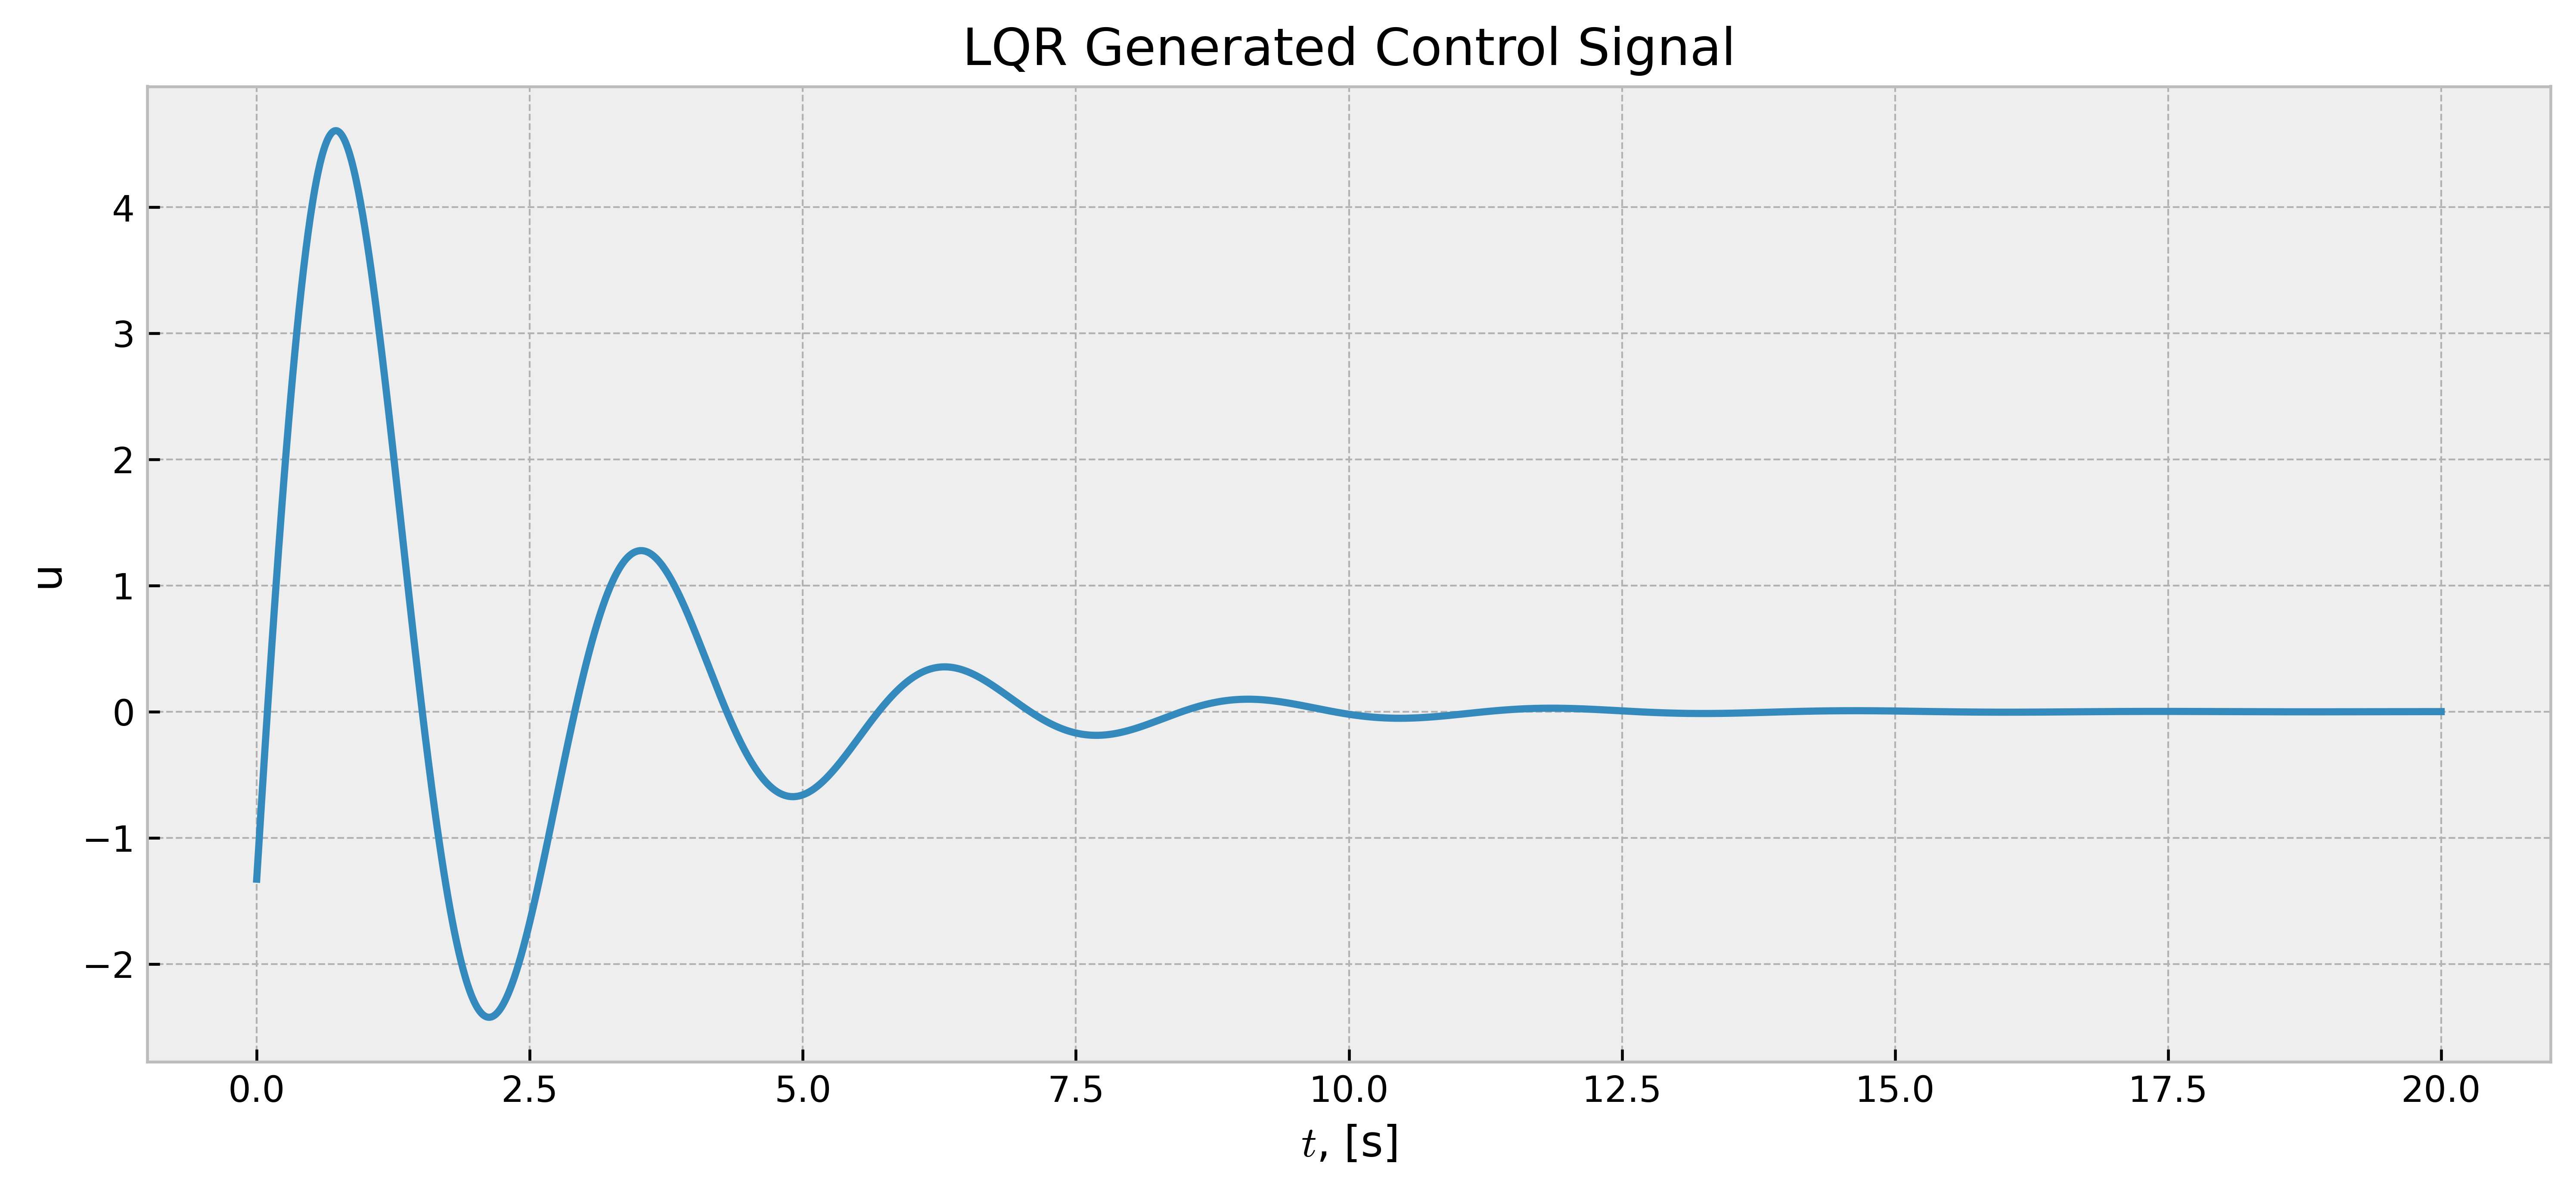

In [28]:
#Control Implementation
u = lambda x: -np.matmul(K, (x - xf))
y1 = solve_ivp(f,[0.0,duration],x0,method='RK45',t_eval=t_span)
#figure
# plt.figure(figsize=figsize, dpi=dpi)
# plt.title("Controlled Angular position and rate")
# plt.plot(t_span,y1.y[0,:],'b-',label = r'$\theta$ - [Rad]')
# plt.plot(t_span,y1.y[1,:],'r--',label = r'$\dot{\theta}$ - [Rad/s]')
# plt.xlabel(r"$t$, [s]")
# plt.ylabel(r"State")
# plt.legend(loc='best')
# plt.show()
y = int(len(t_span))
ctrl2 = np.zeros(y)
yt = y1.y
for o in range(y):
    ynow = yt[:,o]
    ctrl2[o] = -np.matmul(K,(ynow-xf))
plt.figure(figsize=figsize, dpi=dpi)
plt.title("LQR Generated Control Signal")
plt.plot(t_span,ctrl2)
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"u")
plt.show()

The control is implimented via the function $u = -K(x-x_f)$ where $u$ is the control signal, $x$ is the current state, $x_f$ is the desired state and $K$ is the
gain found through LQR. The above figure is the control signal folling the LQR control law imposed on the pendulum system.

Below we will use the [DMD](https://mathlab.github.io/PyDMD/index.html) algorithm to find the Koopman operator of the
uncontrolled system using the data from the non-linear model. For this run we will not be truncating the data.
<details>
<summary> DMD Algorithm </summary>
    Starting with the systems $x_{k+1} = Ax_k$ and a set of 2 consecutive snap shots $X$ and $X'$ of the format
        $$\bf{\mathbf{X}} =& \begin{bmatrix}
        | && | && && |\\
        \mathbf{x}_1 && \mathbf{x}_2 && \ldots && \mathbf{x}_{m-1}\\
        | && | && && |bf{\mathbf{X}} =& \begin{bmatrix}
        | && | && && |\\
        \mathbf{x}_1 && \mathbf{x}_2 && \ldots && \mathbf{x}_{m-1}\\
        | && | && && |
        \end{bmatrix}
        \bf{\mathbf{X}'} =& \begin{bmatrix}
        | && | && && |\\
        \mathbf{x}_2 && \mathbf{x}_3 && \ldots && \mathbf{x}_{m   }\\
        | && | && && |
        \end{bmatrix}$$
        \end{bmatrix}\\
        \bf{\mathbf{X}'} =& \begin{bmatrix}
        | && | && && |\\
        \mathbf{x}_2 && \mathbf{x}_3 && \ldots && \mathbf{x}_{m   }\\
        | && | && && |
        \end{bmatrix}$$
    1. Take singular value decomposition (SVD) of $X$ <br>
        $$ \bf{\mathbf{X}} \approx U \Sigma V^* $$
        where $*$ denotees the conjugate transpose, $U \in \mathbb{R}^{n\times r}$, $\Sigma \in \mathbb{R}^{r\times r}$ and $V \in \mathbb{R}^{n\times r}$
        $r$ is the rank of the reduced SVD approximation to $X$. In SVD, the columns of $U$ are orthonormal and are POD Modes.
        > Some notes on SVD: The SVD reduction in this equation is exploited at this stage in the algorithm to perform a low-rank truncation of the data; if within the data there is a low-dimensional structure the singular values of $\Sigma$ will rapidly decrease to zero with a finite low number of dominant nodes
    2. The matrix $A$ is then found by the pseudoinverse of $X$ obtained via the SVD:
        $$ A\approx \Bar{A} =& \bf{\mathbf{X}}'\tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^* $$
        Here the matrix $A\approx$ defines a "low-dimensional" linear model of the dynamical system on the POD coordinates:
        $$\tilde{\mathbf{x}}_{k+1} =& \tilde{A}\tilde{\mathbf{x}}_k $$
    3. Now perform the eigendecomposition of $A\approx$:
        $$ AW = W\mathbf{\Lambda} $$
        Here the columns of $W$ are the eigenvectors and $\Lambda$ is a diagonal matrix containing the corresponding eigenvalues
    4. This step is not so necessary to this application but for completion it will be included. To reconstruct the eigendecomposition of $A$ we will use $W$ and $\Lambda$. Since we have the eigenvalues of $A$ to find the corresponding eigenvectors of $A$ (these are the DMD modes!!) we use the folloing equation for $Phi$:
        $$\math{\Phi} =& \math{X}'\mathbf{V\Sigma}^{-1}\mathbf{W}$$


</details>

The A matrix defined by the Koopman Operator found by this method is: [[ 1.00025 -0.04546]
 [ 0.01001  0.9993 ]]
Eigenvalue (0.9997727556325549+0.02133017129068633j): distance from unit circle 5.391124022757765e-07
Eigenvalue (0.9997727556325549-0.02133017129068633j): distance from unit circle 5.391124022757765e-07


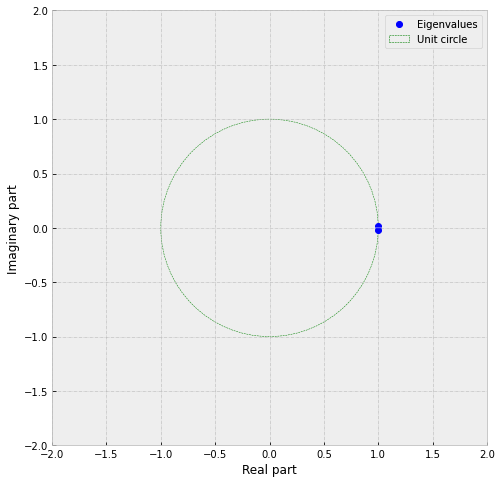

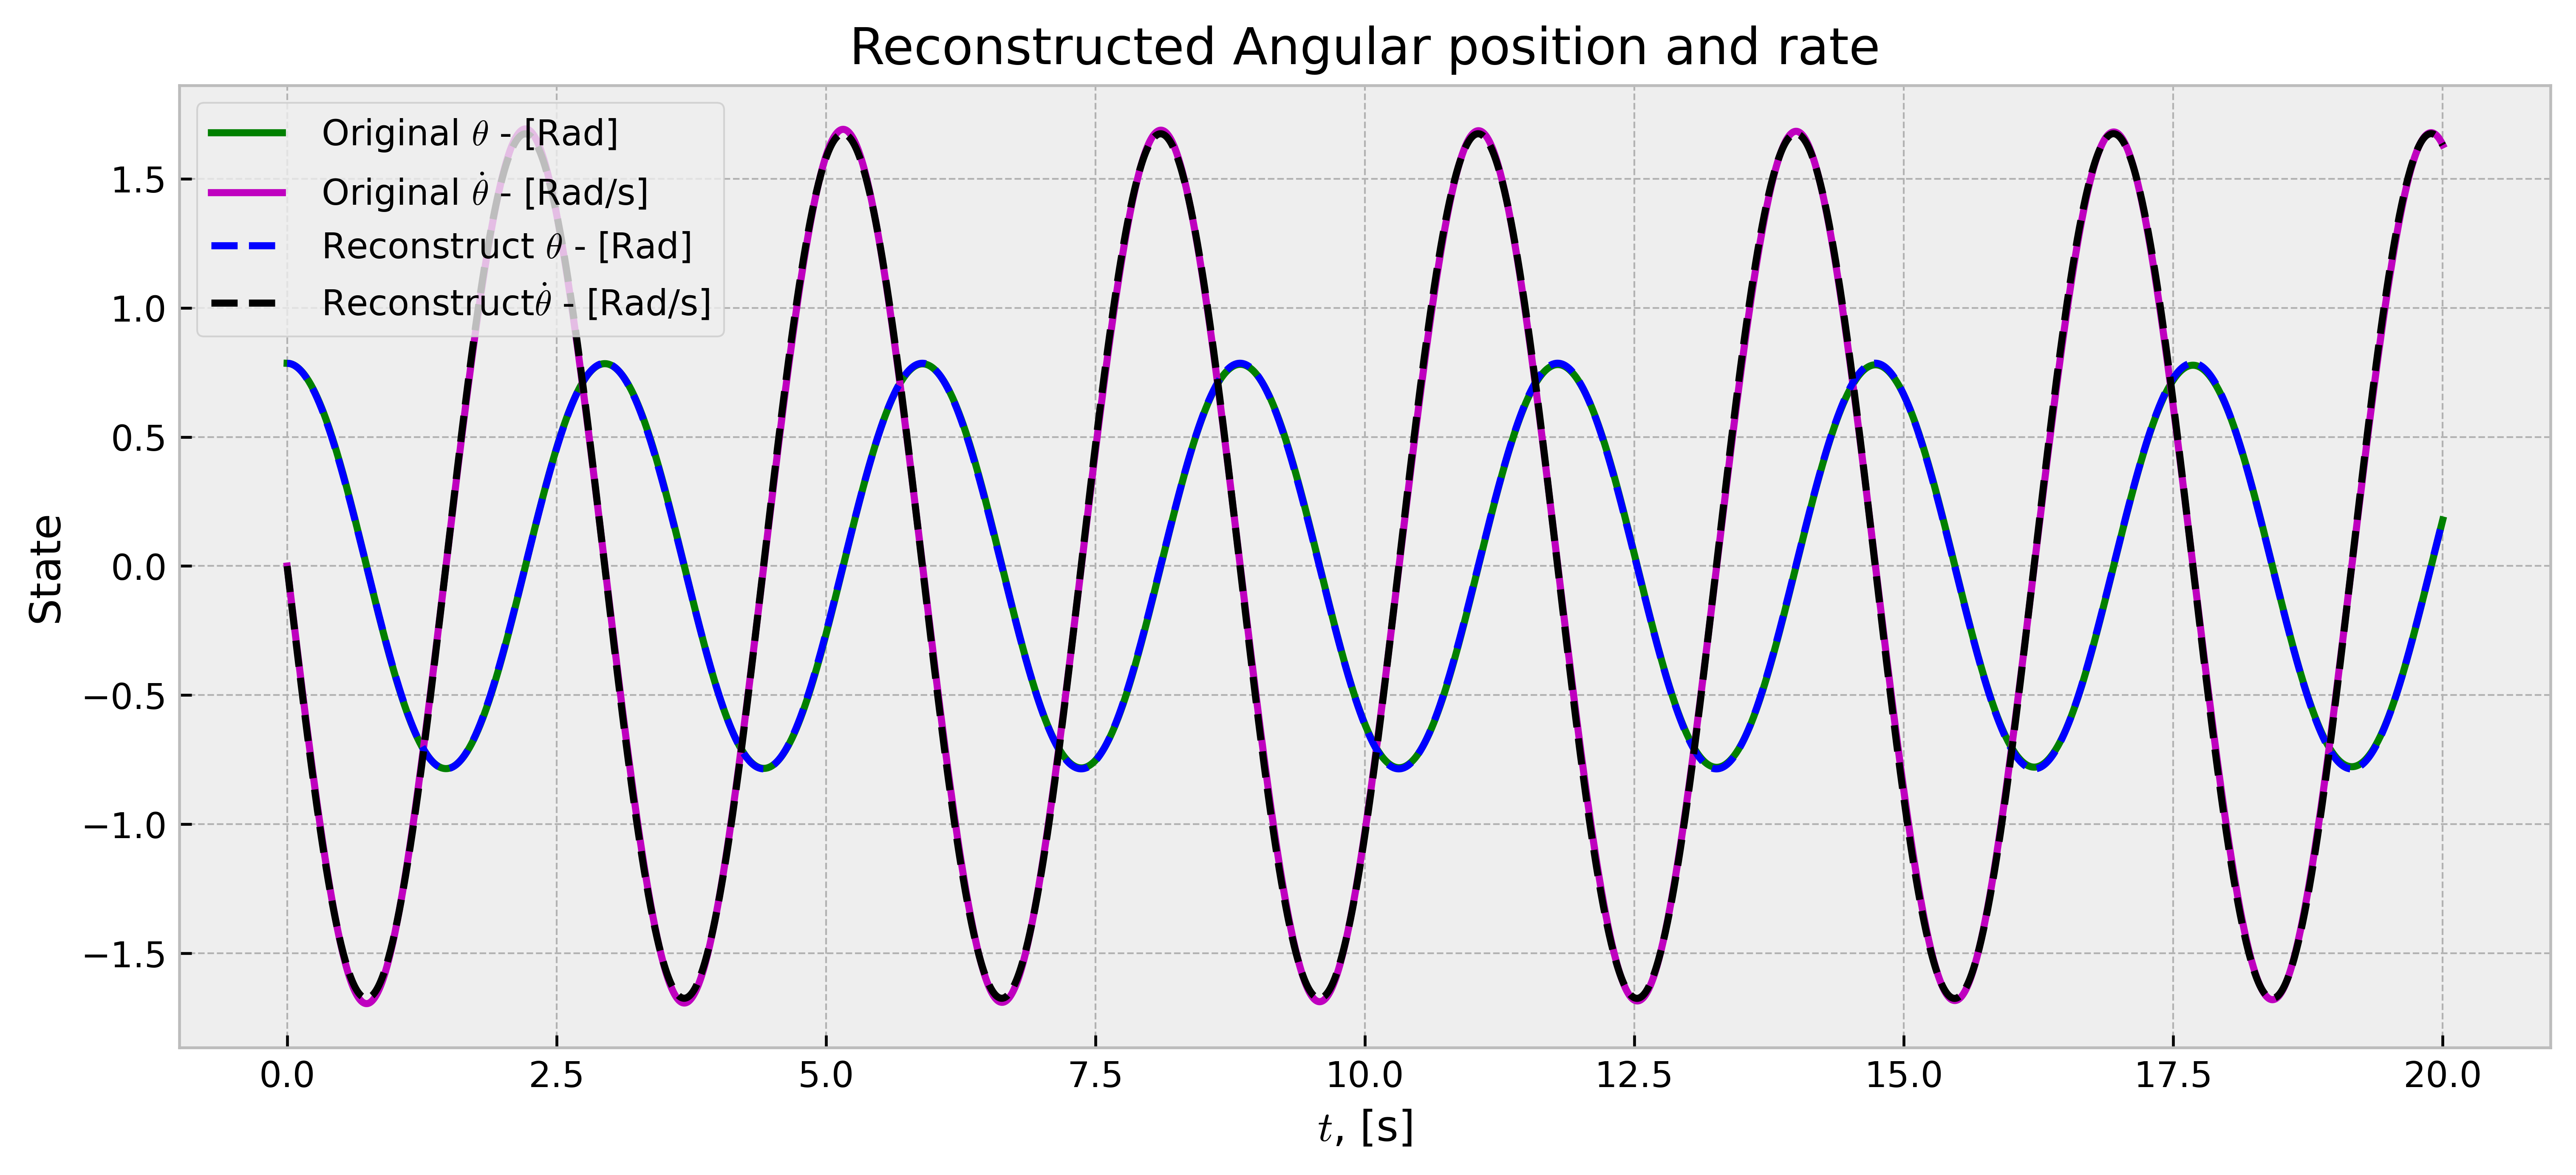

In [29]:
#DMD Time
dmd1 = DMD(svd_rank=2, exact = True)
dmd1.fit(y0.y)
Atilde1 = dmd1.atilde
print('The A matrix defined by the Koopman Operator found by this method is: {}'.format(Atilde1))

for eig in dmd1.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd1.plot_eigs(show_axes=True, show_unit_circle=True)


s1, s2 = np.vsplit(dmd1.reconstructed_data.real,2)
s1 = s1.T
s2 = s2.T
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Reconstructed Angular position and rate")
plt.plot(t_span,y0.y[0,:],'g-',label = r' Original $\theta$ - [Rad]')
plt.plot(t_span,y0.y[1,:],'m-',label = r' Original $\dot{\theta}$ - [Rad/s]')
plt.plot(t_span,s1,'b--',label = r' Reconstruct $\theta$ - [Rad]')
plt.plot(t_span,s2,'k--',label = r' Reconstruct$\dot{\theta}$ - [Rad/s]')

plt.xlabel(r"$t$, [s]")
plt.ylabel(r"State")
plt.legend(loc='best')
plt.show()

We can see a pretty good match between the original and reconstructed data. Will run error analysis later.
## REMEMBER ERROR ANALYSIS EVEN IF YOU THINK ITS USLESS!!!!!!


Now we will perform the same procedure with the controled data to learn the new Koopman Operator for this dynamical system

The A matrix defined by the Koopman Operator found by this method is: [[ 0.99968 -0.0506 ]
 [ 0.00994  0.99065]]
Eigenvalue (0.9951645609058204+0.021972933972944888j): distance from unit circle 0.009164686889746365
Eigenvalue (0.9951645609058204-0.021972933972944888j): distance from unit circle 0.009164686889746365


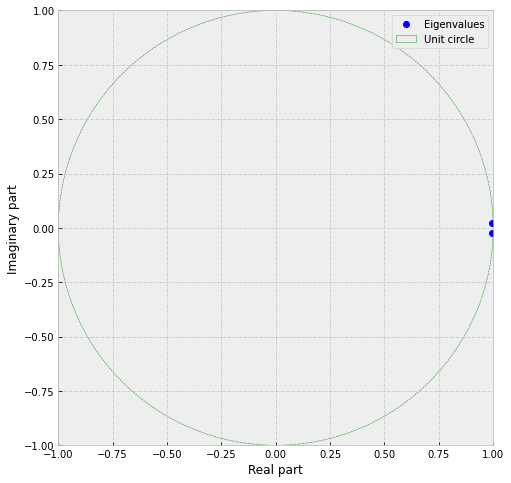

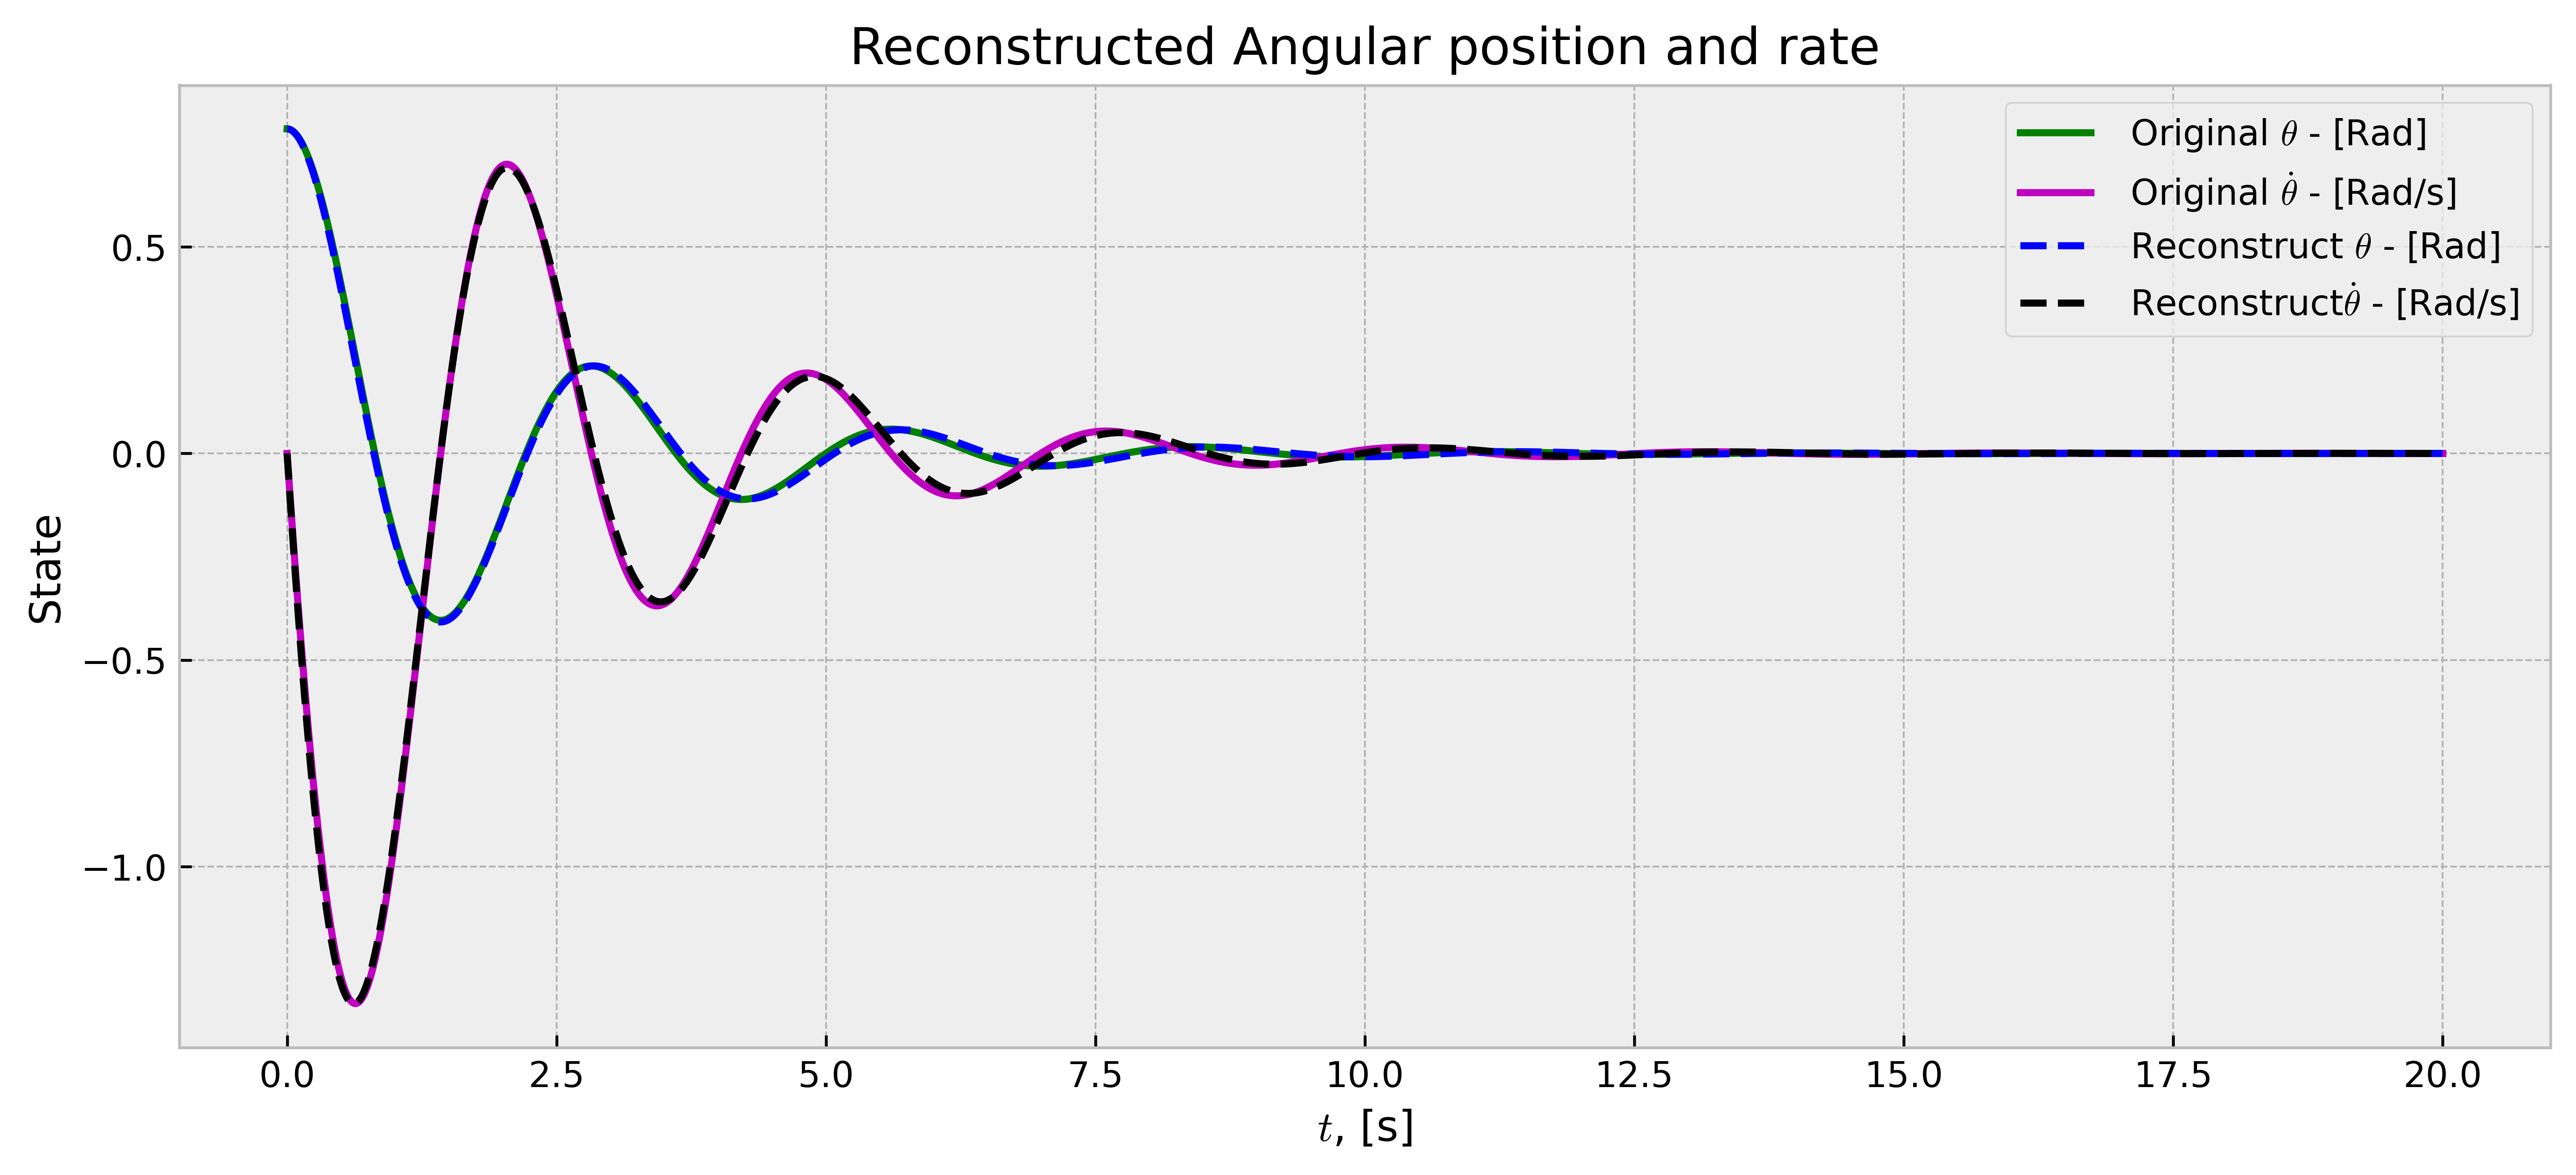

In [30]:
#DMD on Controlled States

#DMD Time
dmd2 = DMD(svd_rank=2, exact = True)
dmd2.fit(y1.y)

Atilde2 = dmd2.atilde
print('The A matrix defined by the Koopman Operator found by this method is: {}'.format(Atilde2))

for eig in dmd2.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd2.plot_eigs(show_axes=True, show_unit_circle=True)

s21, s22 = np.vsplit(dmd2.reconstructed_data.real,2)
s21 = s21.T
s22 = s22.T

plt.figure(figsize=figsize, dpi=dpi)
plt.title("Reconstructed Angular position and rate")
plt.plot(t_span,y1.y[0,:],'g-',label = r' Original $\theta$ - [Rad]')
plt.plot(t_span,y1.y[1,:],'m-',label = r' Original $\dot{\theta}$ - [Rad/s]')

plt.plot(t_span,s21,'b--',label = r' Reconstruct $\theta$ - [Rad]')
plt.plot(t_span,s22,'k--',label = r' Reconstruct$\dot{\theta}$ - [Rad/s]')
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"State")
plt.legend(loc='best')
plt.show()

## As before, remember to make some error analysis of the two sets of data

Next we will go through putting the uncontrolled data through the DMDc algorithm. The control input for DMDc will be the
an array of zeros. The reconstructed data for DMDc should be identical to DMD's in this test

c:\python\lib\site-packages\pydmd\dmdc.py:130: RuntimeWarning: divide by zero encountered in reciprocal
  np.diag(np.reciprocal(sp)), Up1.T.conj(), Ur])
c:\python\lib\site-packages\pydmd\dmdc.py:145: RuntimeWarning: divide by zero encountered in reciprocal
  self._modes = np.linalg.multi_dot([Y, Vp, np.diag(np.reciprocal(sp)),
c:\python\lib\site-packages\pydmd\dmdc.py:135: RuntimeWarning: divide by zero encountered in reciprocal
  np.diag(np.reciprocal(sp)), Up2.T.conj()])


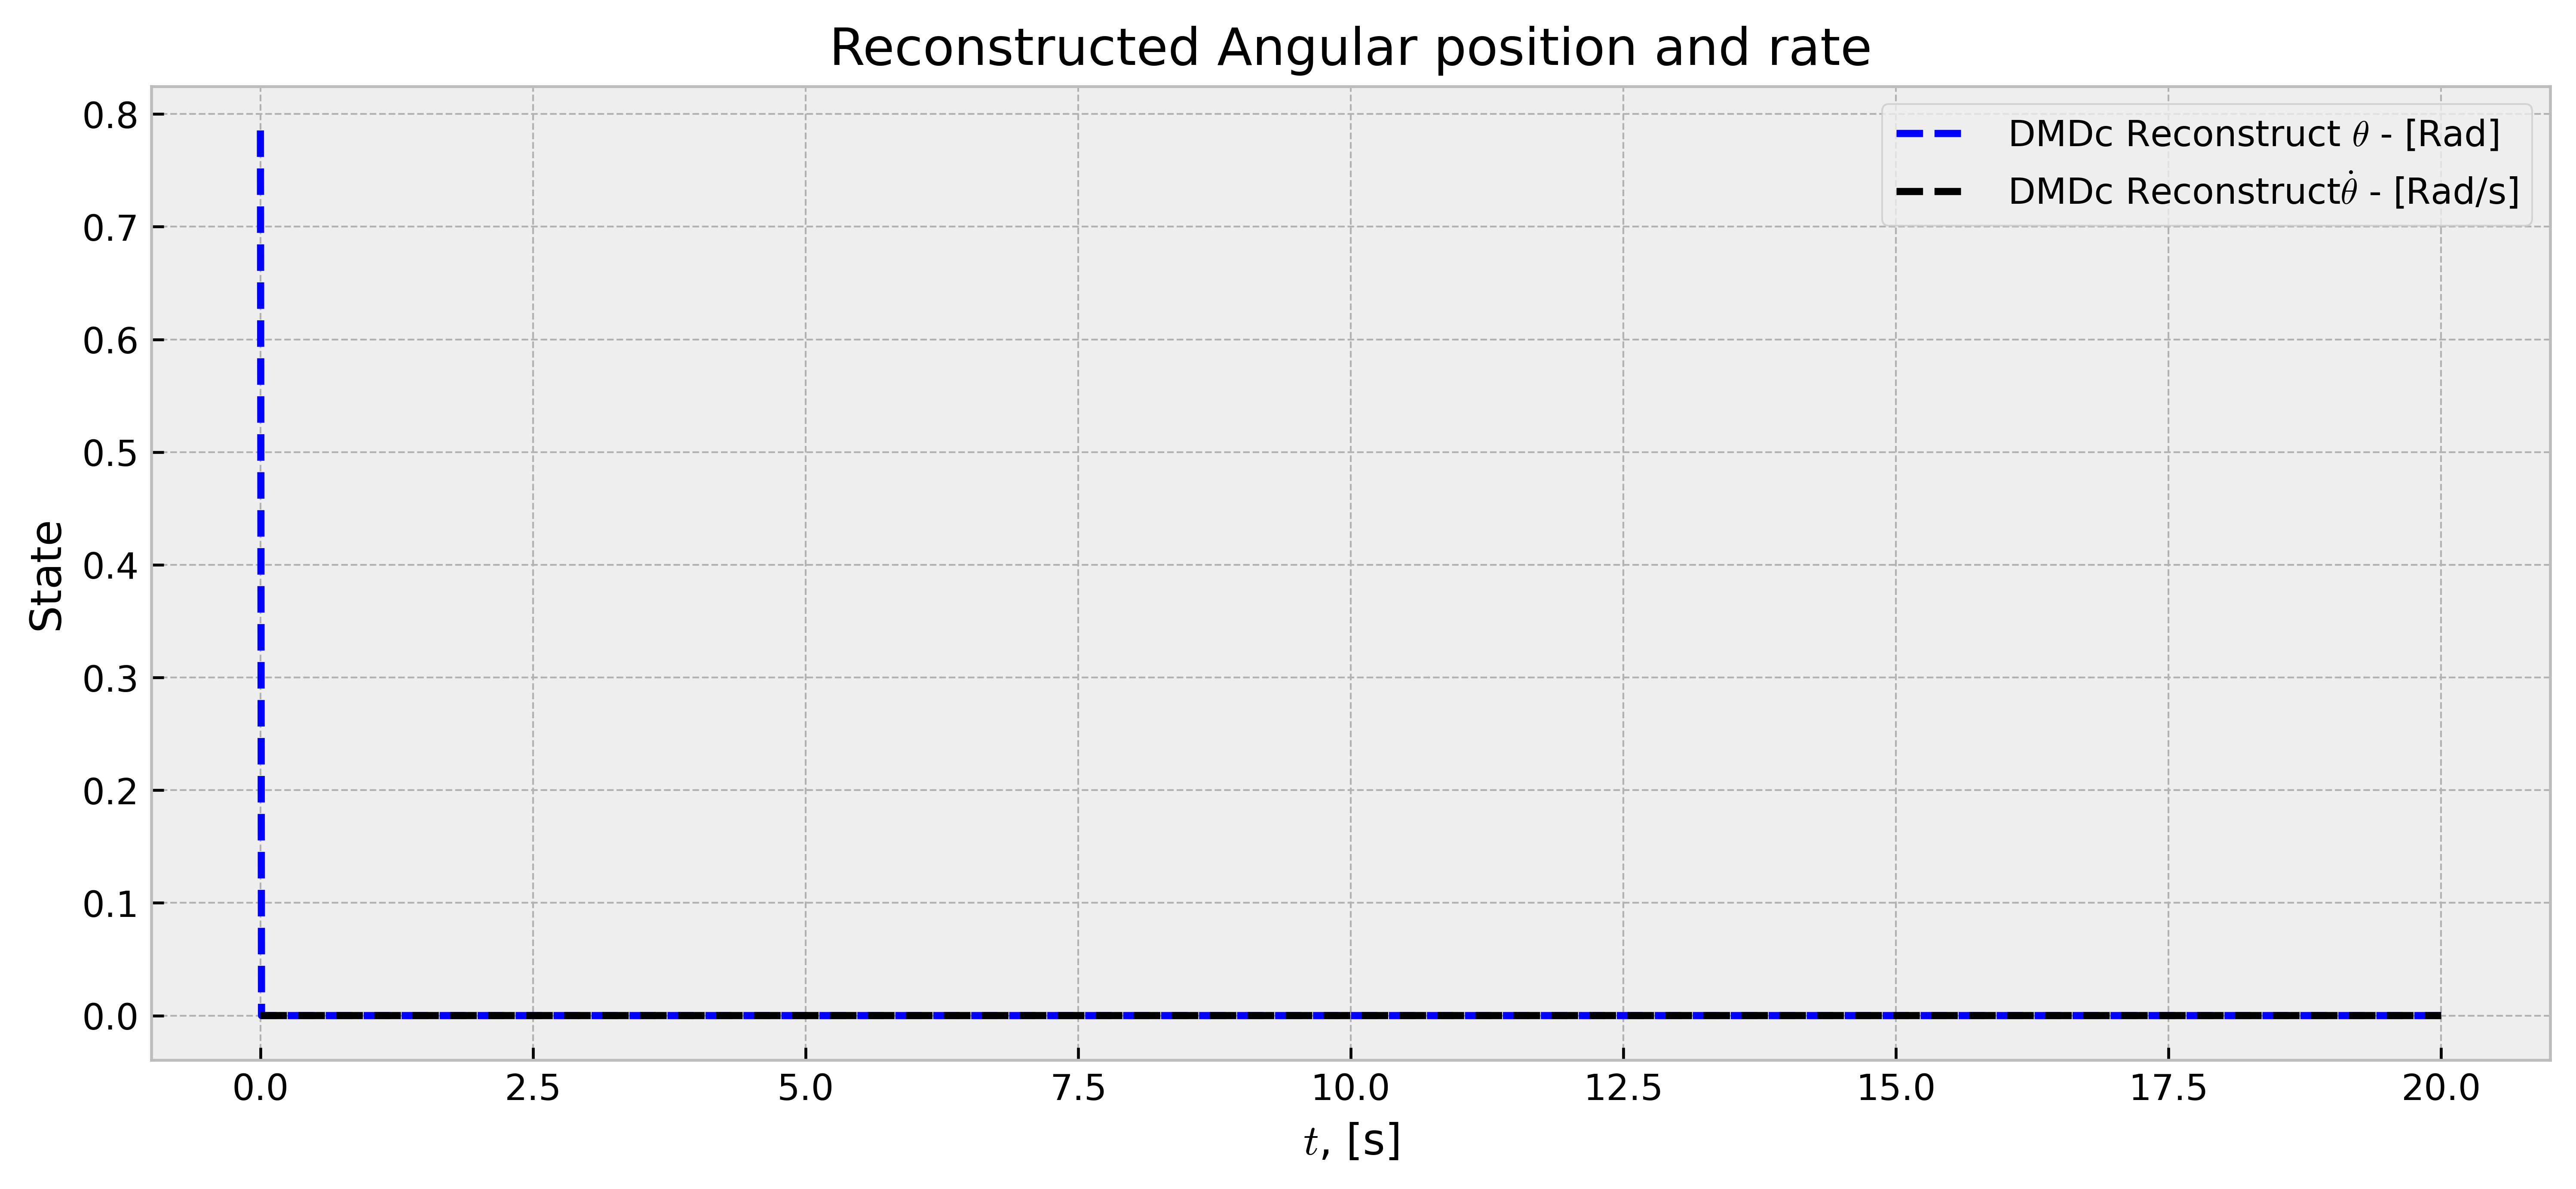

In [44]:
#DMDc on uncontrolled data
ctrl1 = np.zeros((len(y0.y[0])-1))
dmd1c = DMDc()
dmd1c.fit(y0.y,ctrl1.T)
s1, s2 = np.vsplit(dmd1c.reconstructed_data(),2)
s31 = s1.T
s32 = s2.T
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Reconstructed Angular position and rate")
#.plot(t_span,y0.y[0,:],'g-',label = r' Original $\theta$ - [Rad]')
#plt.plot(t_span,y0.y[1,:],'m-',label = r' Original $\dot{\theta}$ - [Rad/s]')
plt.plot(t_span,s31,'b--',label = r' DMDc Reconstruct $\theta$ - [Rad]')
plt.plot(t_span,s32,'k--',label = r' DMDc Reconstruct$\dot{\theta}$ - [Rad/s]')
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"State")
plt.legend(loc='best')
plt.show()

Weird.....
So looks like pyDMD does not like inputing 0 control on the system

In [ ]:
Here we will make our 'lifting' function. In this example I will be using a pool data function from
 ["Discovering Governing Equations from Data: Sparse Identification of Nonlinear Dynamical Systems" by S. L. Brunton, J. L. Proctor, and J. N. Kutz](10.1073/pnas.1517384113)



In [ ]:
def pool(yin, nVars, porder, sorder, yout=None):
    ind = 1
    for i in (1,nVars):#    poly order 1
        yout[:,ind] = yin[:,i]
        ind = ind+1
    if porder>=2: # poly order 2
        for i in (1,nVars):
            for j in (i,nVars):
                yout[:,ind] = yin[:,i] * yin[:,j]
                ind = ind+1
    if porder >=3:# poly order 3
        for i in (1,nVars):
            for j in (i,nVars):
                for k in (j,nVars):
                    yout[:,ind] = yin[:,i]*yin[:,j]*yin[:,k]
                    ind = ind+1
    if porder>=4:# poly order 4
        for i in (1,nVars):
            for j in (i,nVars):
                for k in (j,nVars):
                    for q in (k,nVars):
                        yout[:,ind] = yin[:,i]*yin[:,j]*yin[:,k]*yin[:,q]
                        ind = ind+1
    if sorder == 1:
        for k in (1,sorder):
            yout = np.matrix[yout, np.sin(k*yin), np.cos(k*yin)]
    return yout

#EDMD Time - Lets be cute and only try first order Fourier and order 2 Polynomial
dmd3 = DMD(svd_rank=2, exact = True)
y3 = pool(y0,nvar,polyorder,sineorder)
dmd3.fit(y3.T)
for eig in dmd3.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd3.plot_eigs(show_axes=True, show_unit_circle=True)


s1, s2 = np.vsplit(dmd3.reconstructed_data.real,2)
s1 = s1.T
s2 = s2.T
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Reconstructed Angular position and rate")
plt.plot(t_span,y0[:,0],'g-',label = r' Original $\theta$ - [Rad]')
plt.plot(t_span,y0[:,1],'m-',label = r' Original $\dot{\theta}$ - [Rad/s]')
plt.plot(t_span,s1,'b--',label = r' Reconstruct $\theta$ - [Rad]')
plt.plot(t_span,s2,'k--',label = r' Reconstruct$\dot{\theta}$ - [Rad/s]')

plt.xlabel(r"$t$, [s]")
plt.ylabel(r"State")
plt.legend(loc='best')
plt.show()

In [ ]:
dmd4 = DMD(svd_rank=2, exact = True)
y4 = pool(y1,nvar,polyorder,sineorder)
dmd4.fit(y4.T)
for eig in dmd4.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd4.plot_eigs(show_axes=True, show_unit_circle=True)


s1, s2 = np.vsplit(dmd4.reconstructed_data.real,2)
s1 = s1.T
s2 = s2.T
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Reconstructed Angular position and rate")
plt.plot(t_span,y0[:,0],'g-',label = r' Original $\theta$ - [Rad]')
plt.plot(t_span,y0[:,1],'m-',label = r' Original $\dot{\theta}$ - [Rad/s]')
plt.plot(t_span,s1,'b--',label = r' Reconstruct $\theta$ - [Rad]')
plt.plot(t_span,s2,'k--',label = r' Reconstruct$\dot{\theta}$ - [Rad/s]')

plt.xlabel(r"$t$, [s]")
plt.ylabel(r"State")
plt.legend(loc='best')
plt.show()